In [65]:
#Array packages

import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker
import cartopy.feature as cfeature
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


#Trend
#import xarrayMannKendall as XMK
import dask
from dask import delayed



import os
os.chdir(r"G:\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\2_Papers\1_Streamflow Trend analysis")
print(os.getcwd())

G:\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\2_Papers\1_Streamflow Trend analysis


### Trend seasonal 

In [33]:

data=xr.open_mfdataset(f'3_Data/Data_p/2_Station/Gauge_streamflow.nc')
mean_flow=data['streamflow'].resample(time='Y').mean().compute()


In [35]:
index=['mean_flow','fld_flow','drt_flow']
ds=xr.open_mfdataset(f'3_Data/Data_p/2_Station/Gauge_indices.nc')
ds=ds.sel(season="All")
ds['mean_flow']=mean_flow


guage_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv')
station=ds.station.values
index=['fld_flow','drt_flow','mean_flow']
ssn=['All','Pre-monsoon','Monsoon','Post-monsoon','Winter']
MK=['slope','p_value']

d_arr1=xr.DataArray(coords={'index':index,'station':station},dims=['index','station'],name='trend')
d_arr2=xr.DataArray(coords={'index':index,'station':station},dims=['index','station'],name='p_value')
ds_mk=xr.Dataset({'trend':d_arr1,'p_value':d_arr2})

idx=0
result=[]
trnd = pd.DataFrame(index= station)
for stn in station:
    for ind in index:

        data1=ds[ind].sel(station=stn).values
        trend1, h1, p1, z1, Tau1, s1, var_s1, slope1, intercept1 = mk.original_test(data1)
        ds_mk['trend'].loc[{'index': ind, 'station': stn}] =(slope1/np.nanmean(data1))*1000
        ds_mk['p_value'].loc[{'index': ind, 'station': stn}] = p1
            
ds_mk.to_netcdf(r'2_Streamflow_Analysis\3_Trend analysis\output\Gauge_indices_trend.nc')


C:\Users\2024CEZ8029\AppData\Local\Temp\ipykernel_17424\3342377236.py:25: RuntimeWarning: invalid value encountered in scalar divide
  ds_mk['trend'].loc[{'index': ind, 'station': stn}] =(slope1/np.nanmean(data1))*1000


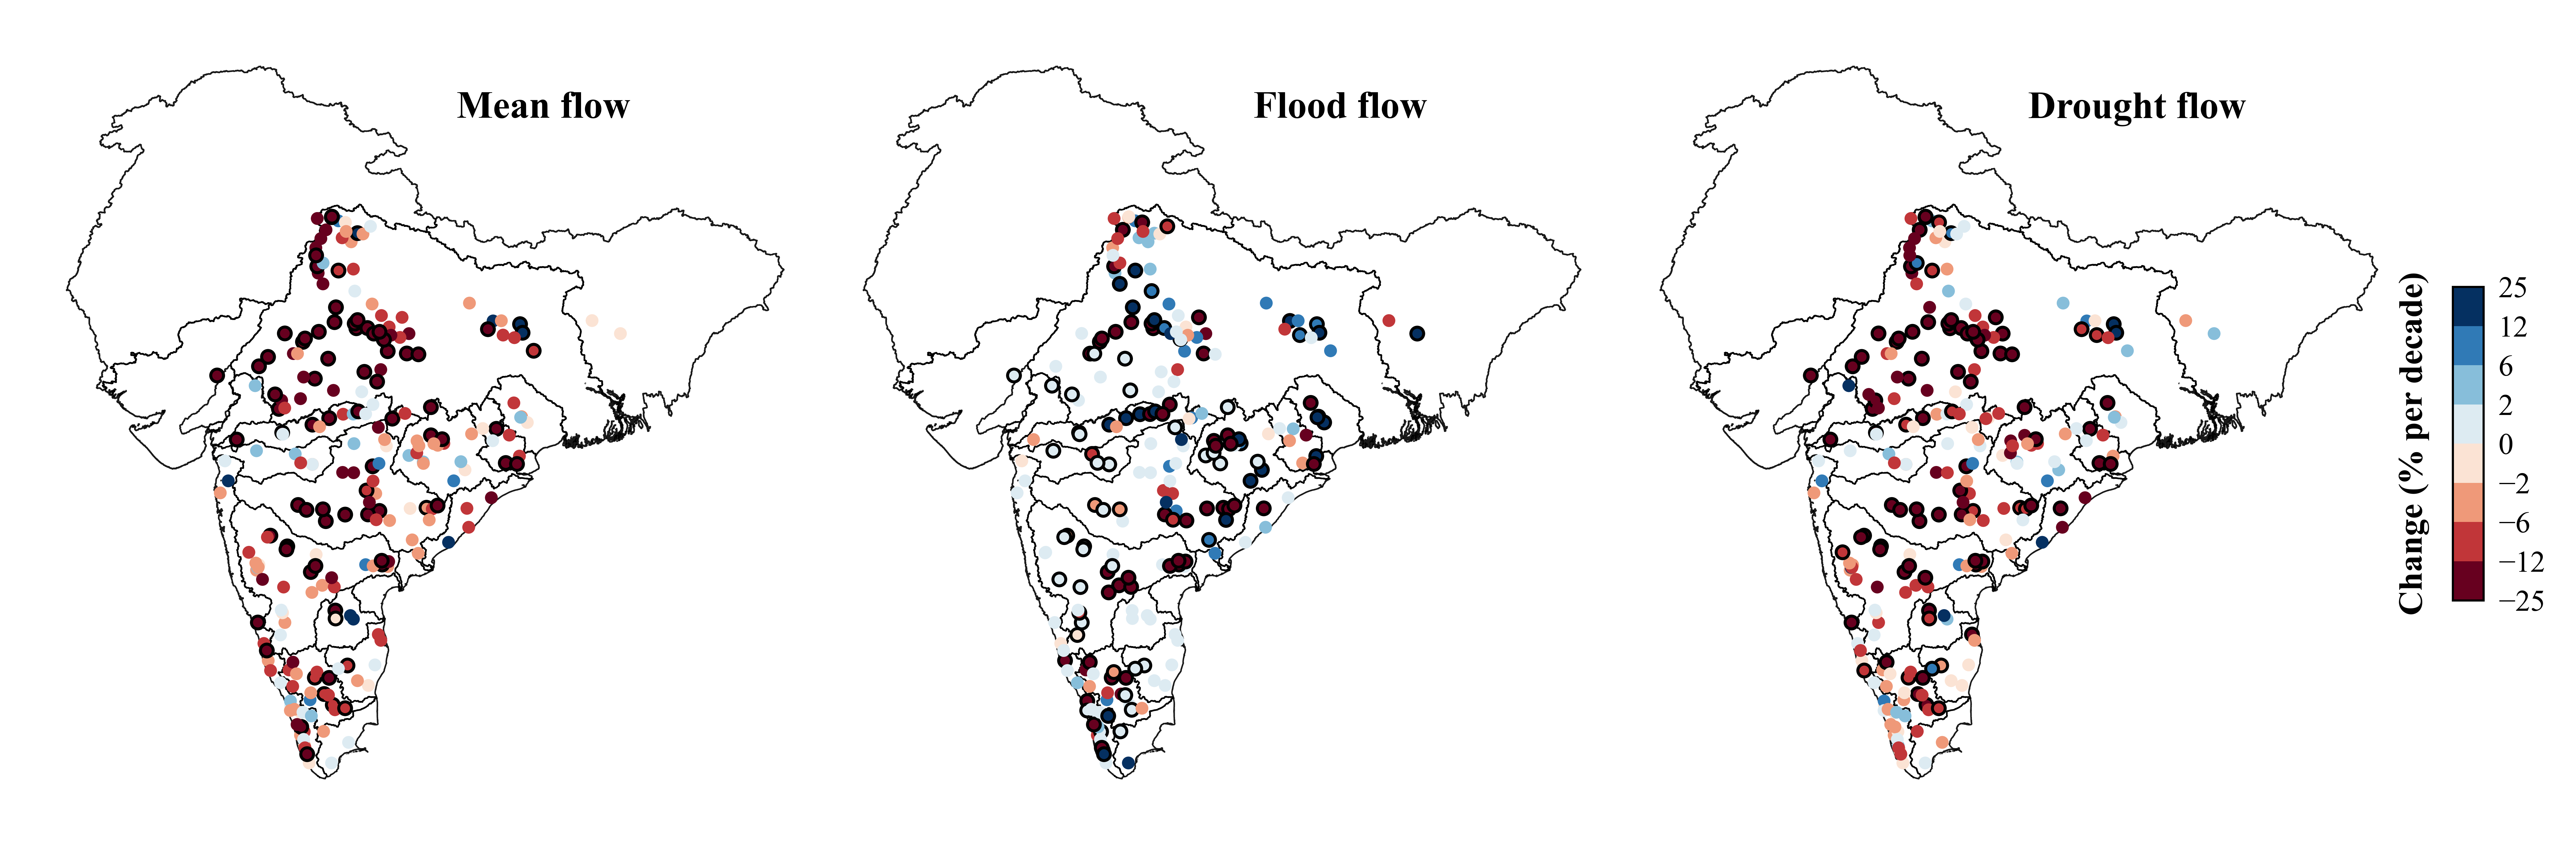

In [46]:
import scienceplots
import matplotlib.image as mpimg
from matplotlib.colors import BoundaryNorm
plt.rcParams['font.family'] = 'Times New Roman'

#plt.style.use(['science','no-latex','bright'])
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = [  'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif']


num_colors = 50;marker_size = 6;marker_size2 = 5;alp = 0.1;alph = 0.05
basinEdge = 'black';basinEdge1 = 'blue';basinLine = 0.35


# Loading maps
guage_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv')
guage_info=guage_info[['GaugeID', 'Station', 'Latitude', 'Longitude']]
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

basin_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/IndiShape/IndShape.shp')
riv_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/India_streams/India_stream.shp')
ind_map=gpd.read_file('3_Data/DATA_r/3_shapefiles_new/india_admin/Country/India_country.shp')



fig, ax1 = plt.subplots(1,3, figsize=(10,4), subplot_kw={"projection": ccrs.PlateCarree()},dpi=1000)
i=0

for id,ind in enumerate(index):

    guage_info['trend']=ds_mk['trend'].loc[{'index': ind}]
    guage_info['p_value']=ds_mk['p_value'].loc[{'index': ind}]
    guage_info['edge']=np.where(guage_info['p_value']<0.05,0.7,0)           # To mark circle in significance points

    #Axis setting
    [x.set_visible(False) for x in ax1[i].spines.values()]
    [x.set_linewidth(0.1) for x in ax1[i].spines.values()]


    #####Plot#####
    cmap1='RdBu'
    levels = [-25,-12,-6,-2,0,2,6,12,25]
    cmap = plt.get_cmap(cmap1)
    #norm = PowerNorm(gamma=0.5, vmin=min(levels), vmax=max(levels)) 
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    south_asia.plot(ax=ax1[i],color = 'none',edgecolor = basinEdge,linewidth=basinLine,alpha=0.9)
    #ind_map.plot(ax=ax1[i],color = 'none',linestyle='--',alpha=0.7,linewidth=basinLine)
    #riv_map.plot(ax=ax1[i],color = 'blue',alpha=0.8,linewidth=basinLine*0.1)
    #xrr2['trend'].plot(ax=ax1[i],cmap='RdBu',vmin=-0.02,vmax=0.02)

    c1=np.repeat(['white'],len(guage_info['Latitude']))
    sc=ax1[i].scatter(guage_info['Longitude'],guage_info['Latitude'],edgecolor='black', linewidth=guage_info['edge'],c=guage_info['trend'],s=9,cmap=cmap1,norm=norm)
    # Add gridlines and titles for better readability


    ## Texts
    ax1[i].text(0.65, 0.9, ['Mean flow','Flood flow','Drought flow'][id], fontsize=9, color='black',fontname='Times New Roman',weight='bold',
            transform=ax1[i].transAxes, ha='center', va='center')



    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=None, left=None, top=None, right=None, wspace=0.01, hspace=0.01)  


    if ind==index[2]:

        ##### colorbar #######
        lf=ax1[i].get_position().x0
        bt=ax1[i].get_position().y0
        wd=ax1[i].get_position().width
        hg=ax1[i].get_position().height
        cbar_ax = fig.add_axes([lf+wd*1.05, bt + 0.174, 0.01,hg-hg*0.6])
        cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', fraction=0.036, pad=0.04)
        cbar.set_label('Slope')

        cbar.outline.set_linewidth(0.5) 
        cbar.ax.tick_params(axis='both',which='both', labelsize=7,width=2, length=0) 
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_label("Change (% per decade)", fontsize=8, labelpad=5.5,weight='bold')
        #cbar.ax.xaxis.label.set_fontweight('bold')

        # Customize tick labels
        #ticks = [-10,0, 10]
        #cbar.set_ticks(ticks)
        #cbar.set_ticklabels([str(tick) for tick in ticks])
    #plt.tight_layout()
    i=i+1

plt.savefig(r'2_Streamflow_Analysis\3_Trend analysis\output\Gauge_indices_trend.jpeg', bbox_inches='tight',dpi=1000)

## PLOT2 : Accelerating/ Decelerating

In [48]:
matrix = np.array([[1, 2,3,3],
                   [1,2,3,3],
                   [0,1,2,2],
                   [0,0,1,1]])
bl=matrix;gr=np.flip(matrix, axis=0);rd=np.transpose(matrix);pr=np.flip(matrix, axis=1)
C=np.block([[pr, bl],
        [rd, gr]])

import matplotlib.colors as mcolors
col_list=[]
col=['Blues','Purples','Reds','Greens']
for i in range(4):
    cmap = plt.cm.get_cmap(col[i], 30)  # Choose a colormap and number of colors
    colors = [cmap(i) for i in [0,3,18,28]]
    # Convert colors to hexadecimal codes
    hex_colors = np.array([mcolors.to_hex(color) for color in colors])
    col_list.append(hex_colors)

bl1=col_list[0][matrix]
gr1=np.flip(col_list[1][matrix], axis=0)
rd1=np.transpose(col_list[2][matrix])
pr1=np.flip(col_list[3][matrix], axis=1)

col_map = np.block([[pr1, bl1],
                    [rd1, gr1]])



C:\Users\2024CEZ8029\AppData\Local\Temp\ipykernel_17424\1033940651.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(col[i], 30)  # Choose a colormap and number of colors


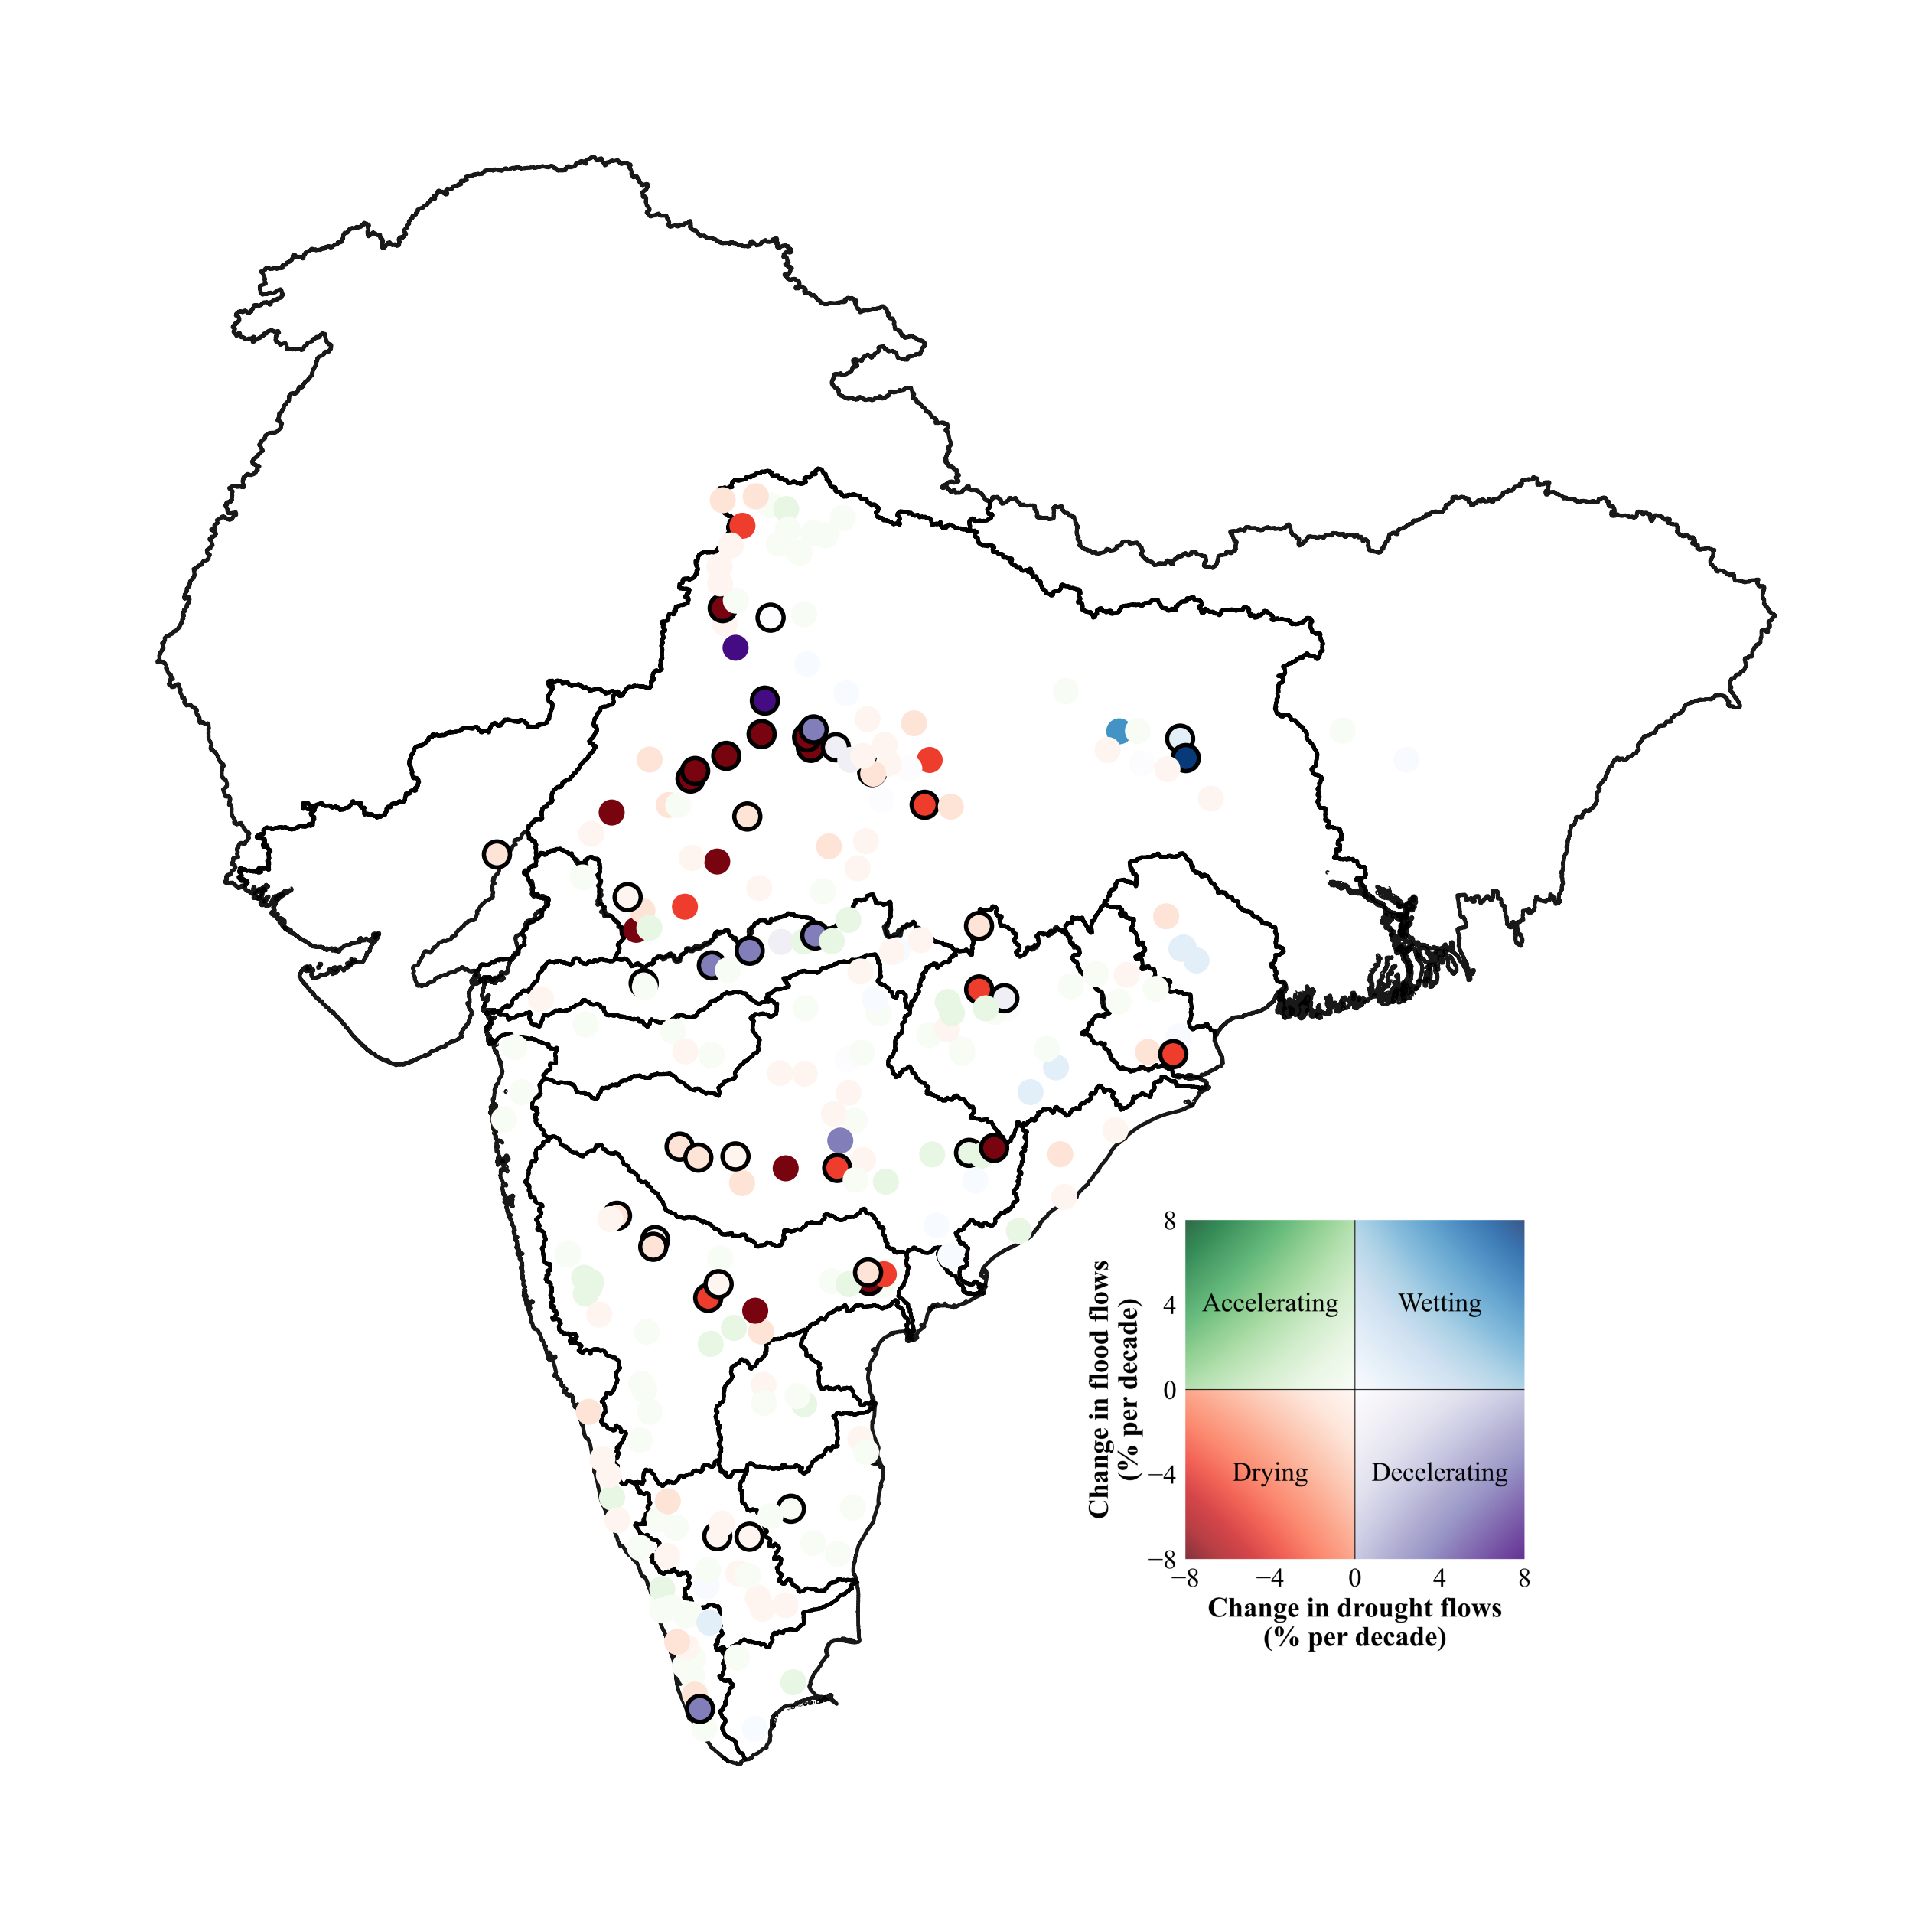

In [64]:
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.image as mpimg

fig, ax = plt.subplots(1, 1, figsize=(4,3), subplot_kw={"projection": ccrs.PlateCarree()},dpi=1000)
i=0

fl=ds_mk.loc[{'index': index[0]}].to_dataframe().drop('index',axis=1)
fl.rename(columns={'trend':'tr_fld','p_value':'p_fld'},inplace=True)

dr=ds_mk.loc[{'index': index[1]}].to_dataframe().drop('index',axis=1)
dr.rename(columns={'trend':'tr_drt','p_value':'p_drt'},inplace=True)
result=dr.join(fl, lsuffix='_df1', rsuffix='_df2')
result['edge']=np.where((result['p_drt']<0.05) & (result['p_fld']<0.05),0.4,0)


scaler = MinMaxScaler(feature_range=(-4, 4))
scaler.fit(np.arange(-30,30,0.1).reshape(-1, 1))

result[['tr_drt','tr_fld']]=result[['tr_drt','tr_fld']].applymap(lambda p : p if (-30 < p <30) else math.copysign(29, p))

result[['row','col']] = result[['tr_fld','tr_drt']].applymap(lambda p: int(np.array(scaler.transform([[p]])).reshape(-1)))

result['col'] = result['col'].apply(lambda p: int(1.1667*p+3.5))
result['row'] = result['row'].apply(lambda p: int(-1.1667*p+3.5))

result['color']=col_map[result['row'],result['col']]
result

#Axis setting
[x.set_visible(False) for x in ax.spines.values()]
[x.set_linewidth(0.1) for x in ax.spines.values()]


#####Plot#####

south_asia.plot(ax=ax,color = 'none',edgecolor = basinEdge,linewidth=basinLine,alpha=0.9)
#ind_map.plot(ax=ax,color = 'none',linestyle='--',alpha=0.7,linewidth=basinLine)
#riv_map.plot(ax=ax,color = 'blue',alpha=0.8,linewidth=basinLine*0.1)
#xrr2['trend'].plot(ax=ax,cmap='RdBu',vmin=-0.02,vmax=0.02)

c1=np.repeat(['white'],len(guage_info['Latitude']))
sc=ax.scatter(guage_info['Longitude'],guage_info['Latitude'],c=result['color'],edgecolor='black', linewidth=result['edge'],s=6)
# Add gridlines and titles for better readability



# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=None, left=None, top=None, right=None, wspace=0.01, hspace=0.01)  

i=i+1

legend_img = mpimg.imread(r'2_Streamflow_Analysis\3_Trend analysis\output\legend1.png')
ax_legend = fig.add_axes([0.5, 0.19, 0.2, 0.2], anchor='NE', zorder=5)
ax_legend.imshow(legend_img)
ax_legend.axis('off')     
plt.savefig(r'2_Streamflow_Analysis\3_Trend analysis\output\Gauge_indices_classification.jpeg', bbox_inches='tight',dpi=1000)

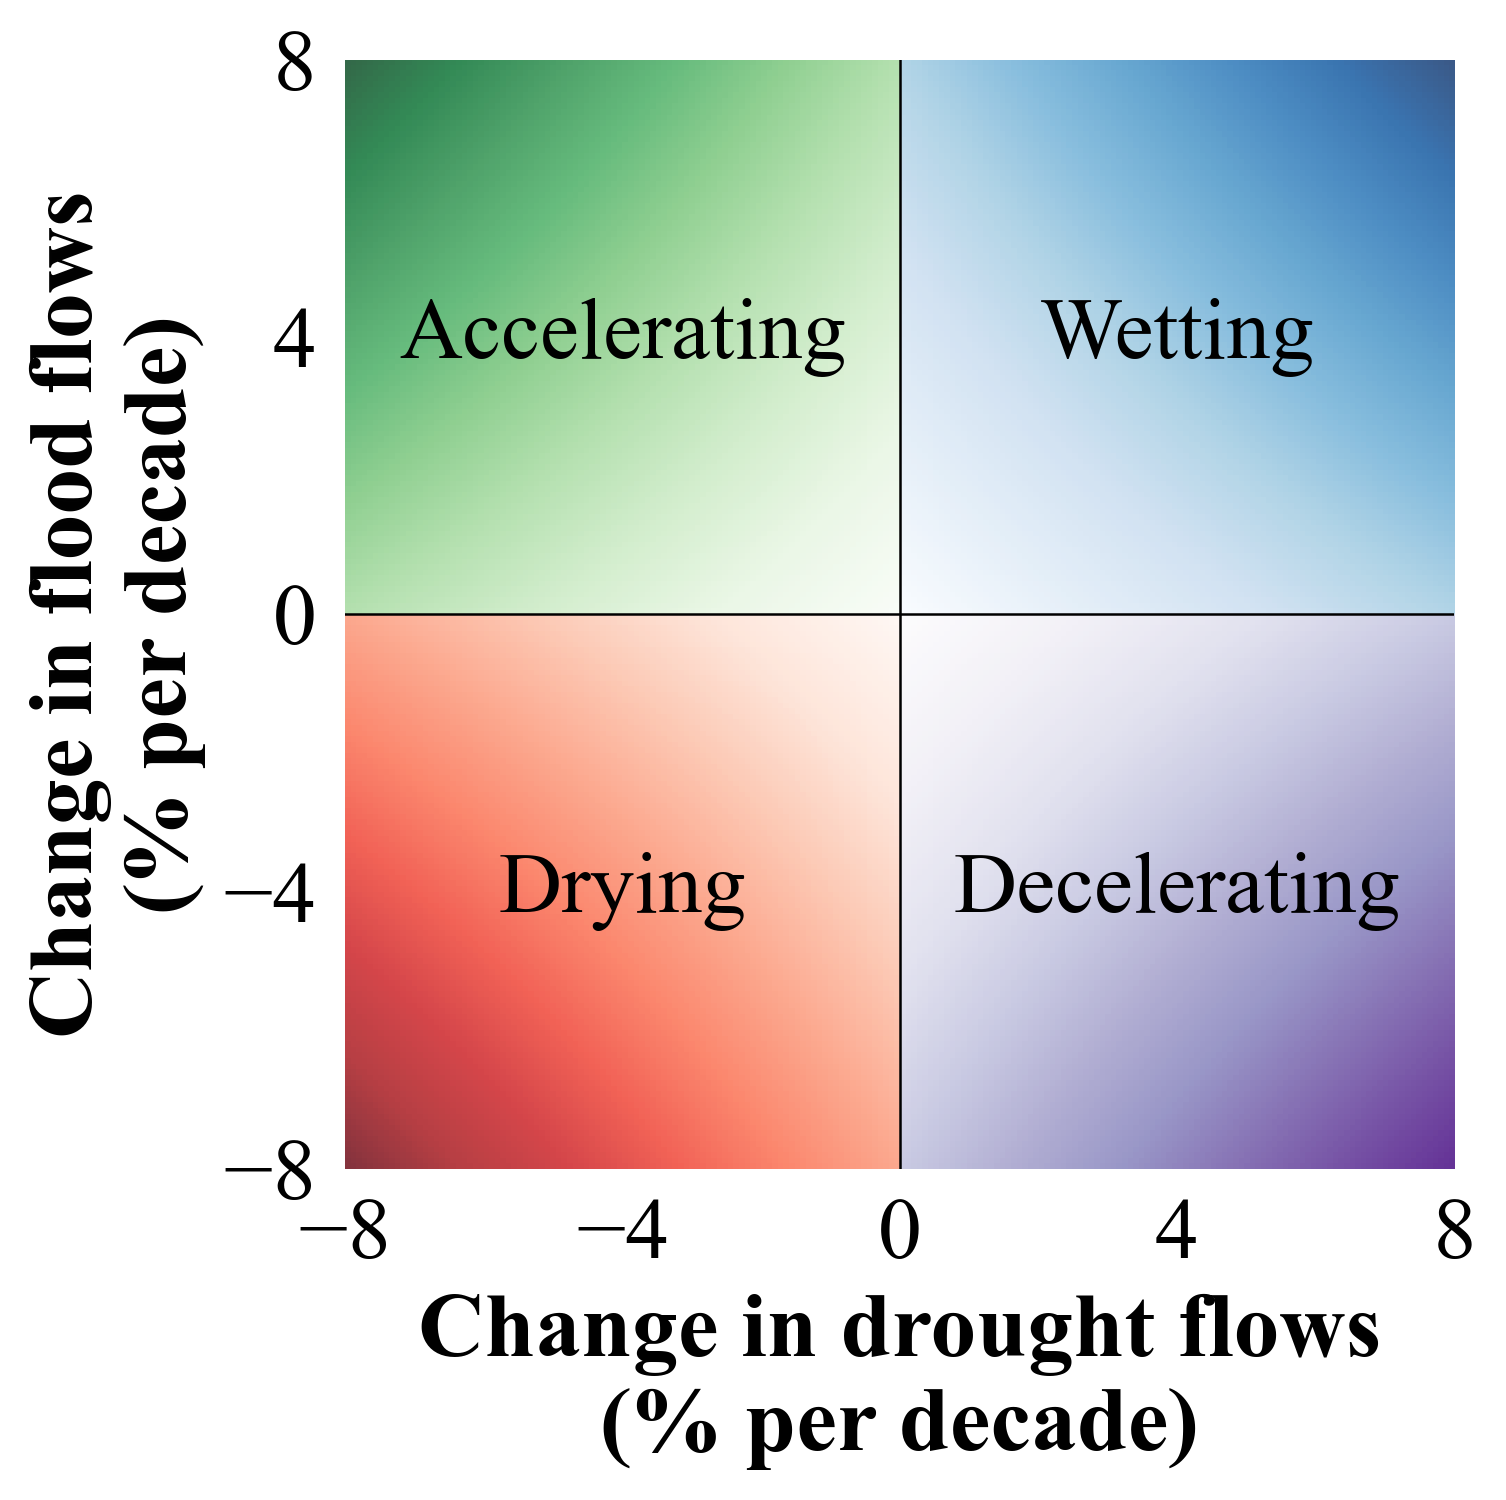

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from matplotlib.ticker import MaxNLocator
plt.rcParams['font.family'] = 'Times New Roman'

# Create the figure and axis
fig, ax = plt.subplots(dpi=300)

# Set the limits for the plot
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

# Create gradient arrays
gradient_up_right = np.outer(np.linspace(0.6, 1, 100), np.linspace(0.6, 1, 100))
gradient_up_left = np.fliplr(gradient_up_right)
gradient_down_right = np.flipud(gradient_up_right)
gradient_down_left = np.flipud(np.fliplr(gradient_up_right))

# Plot the gradients
ax.imshow(gradient_up_right, extent=[0, 8, 0, 8], origin='lower', cmap='Blues', alpha=0.8)
ax.imshow(gradient_up_left, extent=[-8, 0, 0, 8], origin='lower', cmap='Greens', alpha=0.8)
ax.imshow(gradient_down_right, extent=[0, 8, -8, 0], origin='lower', cmap='Purples', alpha=0.8)
ax.imshow(gradient_down_left, extent=[-8, 0, -8, 0], origin='lower', cmap='Reds', alpha=0.8)

# Add text annotations
ax.text(4, 4, 'Wetting', color='Black', fontsize=21, ha='center', va='center')
ax.text(-4, 4, 'Accelerating', color='Black', fontsize=21, ha='center', va='center')
ax.text(-4, -4, 'Drying', color='Black', fontsize=21, ha='center', va='center')
ax.text(4, -4, 'Decelerating', color='Black', fontsize=21, ha='center', va='center')

# Set the labels for the axes
ax.set_xlabel('Change in drought flows\n(% per decade)',fontsize=22,weight='bold')
ax.set_ylabel('Change in flood flows\n(% per decade)',fontsize=22,weight='bold')

# Hide the spines and ticks
for spine in ax.spines.values():
    spine.set_visible(False)

ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')


# Hide the spines and ticks
for spine in ax.spines.values():
    spine.set_visible(False)

ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
ax.tick_params(axis='both', which='major', labelsize=21)
ax.xaxis.set_major_locator(MaxNLocator(4))  # Adjust the number of ticks on x-axis
ax.yaxis.set_major_locator(MaxNLocator(4))

# Draw the x and y axis lines
ax.axhline(0, color='black', linewidth=0.6)
ax.axvline(0, color='black', linewidth=0.6)

plt.savefig(r'2_Streamflow_Analysis\3_Trend analysis\output\legend1.png', bbox_inches='tight',dpi=700)
# Display the plot
plt.show()


## checks

#### colormaps

In [ ]:

# Plotting
fig, ax = plt.subplots(figsize=(8, 2))
for i, color in enumerate(hex_colors):
    ax.bar(i, 1, color=color)

# Customize plot
ax.set_xlim(-0.5, len(hex_colors)-0.5)
ax.set_ylim(0, 1)
ax.set_xticks(range(len(hex_colors)))
ax.set_xticklabels(['Color 1', 'Color 2', 'Color 3'])  # Replace with meaningful labels
ax.set_yticks([])  # Hide y-axis ticks
ax.set_title('Colors from Reds Colormap')

plt.show()

In [55]:
fl=ds_mk.loc[{'index': index[0], 'season': 'Pre-monsoon'}].to_dataframe().drop('index',axis=1)
fl.rename(columns={'trend':'tr_fld','p_value':'p_fld'},inplace=True)

dr=ds_mk.loc[{'index': index[1], 'season': 'Pre-monsoon'}].to_dataframe().drop('index',axis=1)
dr.rename(columns={'trend':'tr_drt','p_value':'p_drt'},inplace=True)
result=dr.join(fl, lsuffix='_df1', rsuffix='_df2')
result['tr_fld'].max()


scaler = MinMaxScaler(feature_range=(-4, 4))
scaler.fit(np.arange(-30,30,0.1).reshape(-1, 1))

result[['tr_drt','tr_fld']]=result[['tr_drt','tr_fld']].applymap(lambda p : p if (-30 < p <30) else math.copysign(29, p))

result[['row','col']] = result[['tr_fld','tr_drt']].applymap(lambda p: int(np.array(scaler.transform([[p]])).reshape(-1)))

result[['row','col']] = result[['tr_fld','tr_drt']].applymap(lambda p: int(np.array(scaler.transform([[p]])).reshape(-1)))
result['row'] = result['row'].apply(lambda p: int(-1.1667*p+3.5))
result['col'] = result['col'].apply(lambda p: int(1.1667*p+3.5))

result['color']=col_map[result['row'],result['col']]
result['edge']=np.where((result['p_drt']<0.05) & (result['p_fld']<0.05),0.4,0)

C:\Users\sstar\AppData\Local\Temp\ipykernel_21304\3940710852.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result[['tr_drt','tr_fld']]=result[['tr_drt','tr_fld']].applymap(lambda p : p if (-30 < p <30) else math.copysign(29, p))
C:\Users\sstar\AppData\Local\Temp\ipykernel_21304\3940710852.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result[['row','col']] = result[['tr_fld','tr_drt']].applymap(lambda p: int(np.array(scaler.transform([[p]])).reshape(-1)))
C:\Users\sstar\AppData\Local\Temp\ipykernel_21304\3940710852.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result[['row','col']] = result[['tr_fld','tr_drt']].applymap(lambda p: int(np.array(scaler.transform([[p]])).reshape(-1)))


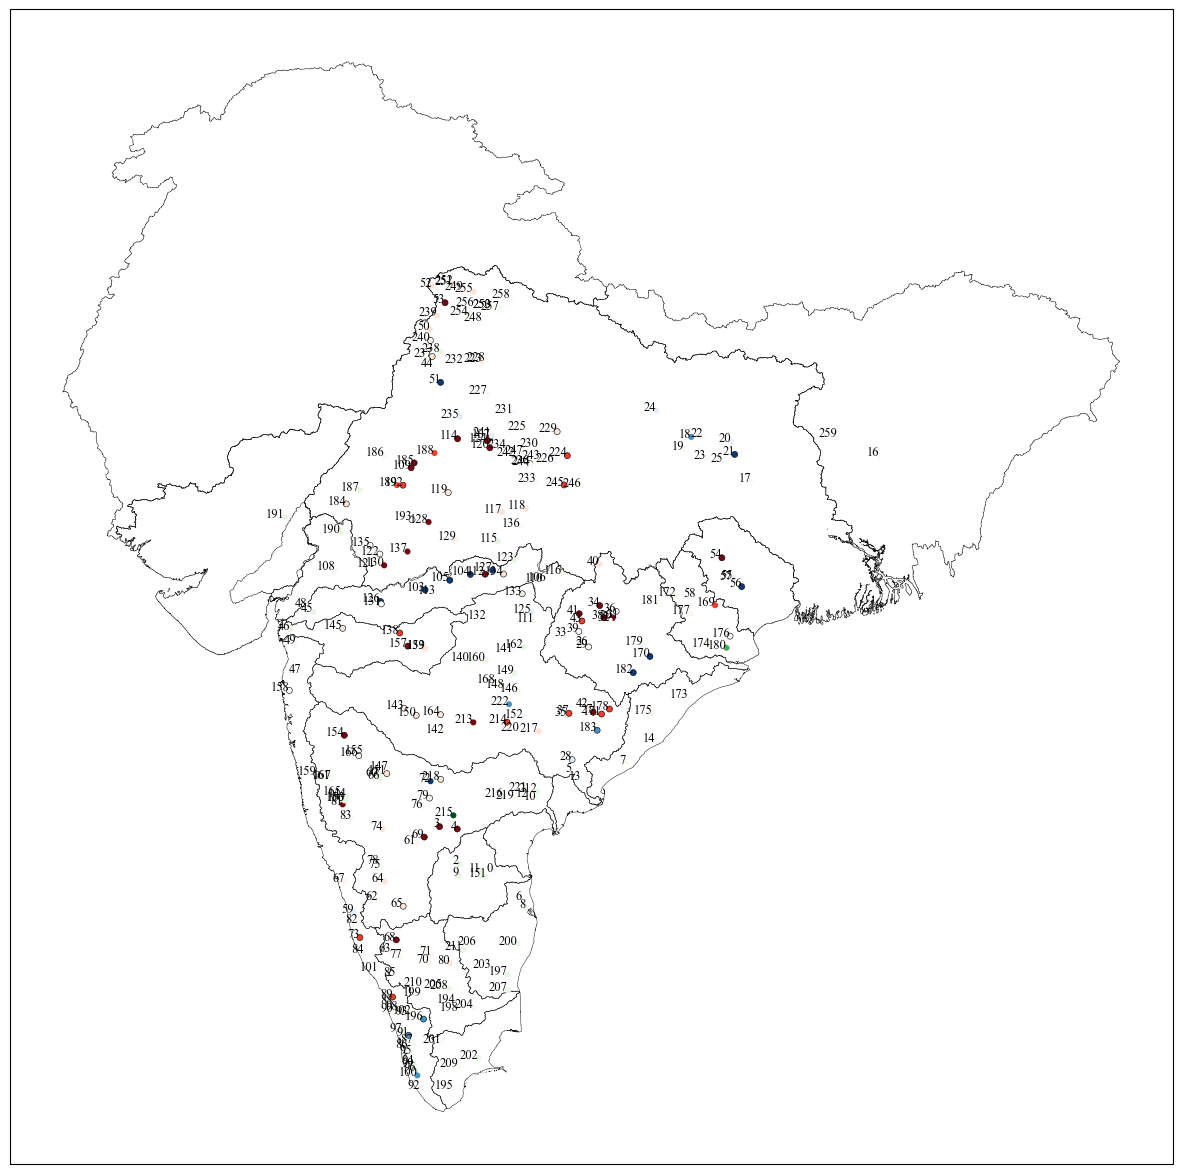

In [56]:
guage_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv')
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

basin_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/IndiShape/IndShape.shp')
riv_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/India_streams/India_stream.shp')
ind_map=gpd.read_file('3_Data/DATA_r/3_shapefiles_new/india_admin/Country/India_country.shp')



fig, ax1 = plt.subplots(figsize=(15,15), subplot_kw={"projection": ccrs.PlateCarree()})

c1=np.repeat(['white'],len(guage_info['Latitude']))

south_asia.plot(ax=ax1,color = 'none',edgecolor = basinEdge,linewidth=basinLine,alpha=0.9)
ax1.scatter(guage_info['Longitude'],guage_info['Latitude'],c=result['color'],edgecolor='black', linewidth=result['edge'],s=19)
for i, row in guage_info.iterrows():
    ax1.annotate(str(i), (row['Longitude'], row['Latitude']), fontsize=9, ha='right')


'Chittorgarh'

In [183]:
A=xr.open_mfdataset(f'3_Data/Data_p/2_Station/Gauge_streamflow.nc')

aa=ds['fld_flow'].sel(station=s,season='Monsoon').values
#A['streamflow'].sel(station=s).rolling(time=7).mean().resample(time='Y').min().plot()



0.2510524600877113

In [67]:

id=184
s=guage_info.loc[id,'Station']
result.loc[guage_info.loc[id,['Station']]]

trend1, h1, p1, z1, Tau1, s1, var_s1, slope1, intercept1 = mk.original_test(data1)
ds_mk['trend'].loc[{'index': ind, 'station': stn, 'season': ss}] =(slope1/np.nanmean(data1))*1000


In [241]:
result[['tr_drt','tr_fld']]=result[['tr_drt','tr_fld']].applymap(lambda p : p if (-30 < p <30) else math.copysign(29, p))

result[['row','col']] = result[['tr_fld','tr_drt']].applymap(lambda p: int(np.array(scaler.transform([[p]])).reshape(-1)))
result['row'] = result['row'].apply(lambda p: int(-1.1667*p+3.5))

result['color']=col_map[result['row'],result['col']]

#result['col'] = result['col'].apply(lambda p: int(1.1667*p+3.5))

C:\Users\sstar\AppData\Local\Temp\ipykernel_18568\173345004.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result[['tr_drt','tr_fld']]=result[['tr_drt','tr_fld']].applymap(lambda p : p if (-30 < p <30) else math.copysign(29, p))
C:\Users\sstar\AppData\Local\Temp\ipykernel_18568\173345004.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result[['row','col']] = result[['tr_fld','tr_drt']].applymap(lambda p: int(np.array(scaler.transform([[p]])).reshape(-1)))


In [184]:
s

'Chittorgarh'